# Single Stock Dual-EWMA Crossover Strategy

- long when fast MA > slow MA
- short when fast MA < slow MA

## Import libraries

In [1]:
pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy import stats
plt.style.use("seaborn-whitegrid")

## Load stock data

In [3]:
ticker = "AAPL"
aapl_df = yf.download(tickers=ticker, period="max", interval="1d", group_by="ticker", auto_adjust=True)
aapl_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
1980-12-12,0.100600,0.101037,0.100600,0.100600,469033600
1980-12-15,0.095789,0.095789,0.095352,0.095352,175884800
1980-12-16,0.088790,0.088790,0.088353,0.088353,105728000
1980-12-17,0.090540,0.090977,0.090540,0.090540,86441600
1980-12-18,0.093165,0.093602,0.093165,0.093165,73449600
...,...,...,...,...,...
2021-08-06,146.350006,147.110001,145.630005,146.139999,54067400
2021-08-09,146.199997,146.699997,145.520004,146.089996,48908700
2021-08-10,146.440002,147.710007,145.300003,145.600006,68922200


## Get close prices

In [4]:
close_df = aapl_df.copy()
close_df = close_df.drop(columns=["Open", "High", "Low", "Volume"])
close_df = close_df.rename(columns={"Close":"AAPL"})
close_df

,AAPL
Date,
1980-12-12,0.100600
1980-12-15,0.095352
1980-12-16,0.088353
1980-12-17,0.090540
1980-12-18,0.093165
...,...
2021-08-06,146.139999
2021-08-09,146.089996
2021-08-10,145.600006


## Visualise adjusted close prices

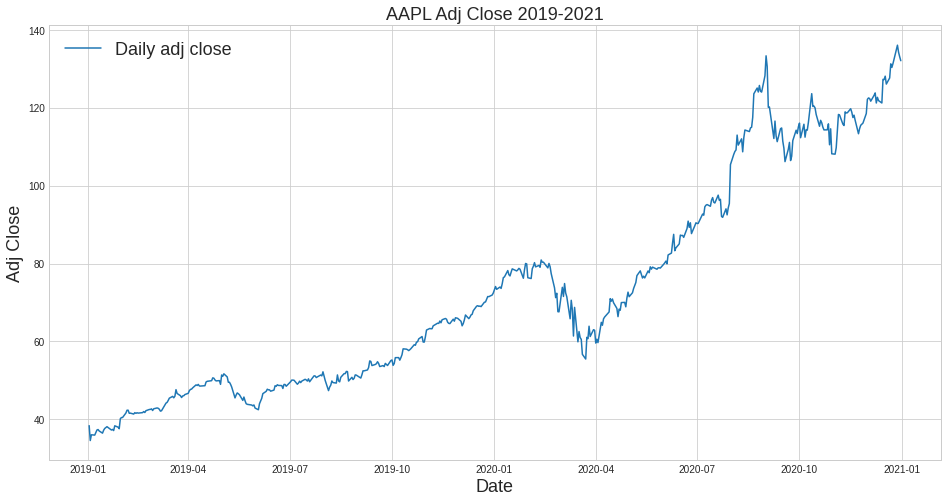

In [5]:
plt.figure(figsize=(16,8))
plt.plot(close_df.loc["2019-01-01":"2021-01-01", "AAPL"], label="Daily adj close")
plt.title("AAPL Adj Close 2019-2021", fontsize=18)
plt.legend(fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Adj Close", fontsize=18)
plt.show()

## Exponentially Weighted Moving Average (EWMA)

In [6]:
def EWMA(df, period):
  return df.ewm(span=period).mean()

In [7]:
fast_ewma_df = close_df.copy()
fast_ewma_df = EWMA(fast_ewma_df, 21)
fast_ewma_df

,AAPL
Date,
1980-12-12,0.100600
1980-12-15,0.097851
1980-12-16,0.094379
1980-12-17,0.093278
1980-12-18,0.093251
...,...
2021-08-06,144.768334
2021-08-09,144.888485
2021-08-10,144.953169


In [8]:
slow_ewma_df = close_df.copy()
slow_ewma_df = EWMA(slow_ewma_df, 125)
slow_ewma_df

,AAPL
Date,
1980-12-12,0.100600
1980-12-15,0.097955
1980-12-16,0.094703
1980-12-17,0.093637
1980-12-18,0.093540
...,...
2021-08-06,132.882666
2021-08-09,133.092306
2021-08-10,133.290841


## Visualise EWMAs with adjusted close prices

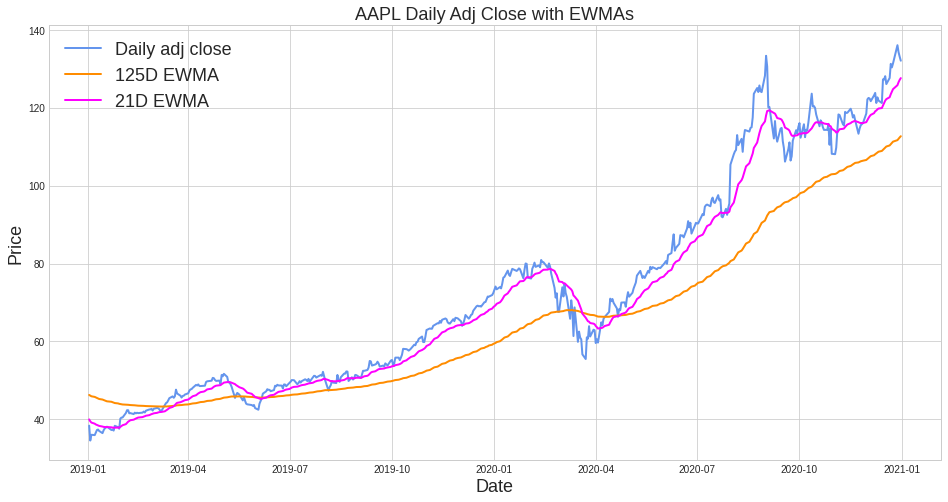

In [9]:
plt.figure(figsize=(16,8))
plt.plot(close_df.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="Daily adj close", linewidth=2, color="cornflowerblue", zorder=1)
plt.plot(slow_ewma_df.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="125D EWMA", linewidth=2, color="darkorange", zorder=2)
plt.plot(fast_ewma_df.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="21D EWMA", linewidth=2, color="magenta", zorder=3)
plt.title("AAPL Daily Adj Close with EWMAs", fontsize=18)
plt.legend(fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.show()

## Compute long and short signals

- long when fast MA > slow MA
- short when fast MA < slow MA

In [10]:
def get_long_short(fast_ma, slow_ma):
  # create initial long/short signal dataframe with all zeros
  long_short = (fast_ma*0).fillna(0).astype(np.int)
  # create long signals when close > moving avg
  long_signals = (fast_ma > slow_ma).astype(np.int)
  # create short signals when close < moving avg
  short_signals = (fast_ma < slow_ma).astype(np.int)
  # combine both long and short signals
  long_short = long_short + long_signals - short_signals

  return long_short

In [11]:
# compute signals b/w 2019 and 2021 and cut ewma and close to that timeframe too
close_df = close_df.loc["2019-01-01":"2021-01-01", :]
fast_ewma_df = fast_ewma_df.loc["2019-01-01":"2021-01-01", :]
slow_ewma_df = slow_ewma_df.loc["2019-01-01":"2021-01-01", :]
signal = get_long_short(fast_ewma_df, slow_ewma_df)
signal

,AAPL
Date,
2019-01-02,-1
2019-01-03,-1
2019-01-04,-1
2019-01-07,-1
2019-01-08,-1
...,...
2020-12-24,1
2020-12-28,1
2020-12-29,1


## Filter signal

Filter out all consecutive-equal signals, so only long/short changes remain.

In [12]:
def filter_signal(signal):

  filtered_signal = signal.copy()
  for ticker in filtered_signal:
    filtered_signal.loc[filtered_signal[ticker].shift(1).eq(filtered_signal[ticker]), ticker] = 0
  
  return filtered_signal

In [13]:
filtered_signal = filter_signal(signal)
filtered_signal

,AAPL
Date,
2019-01-02,-1
2019-01-03,0
2019-01-04,0
2019-01-07,0
2019-01-08,0
...,...
2020-12-24,0
2020-12-28,0
2020-12-29,0


## Visualise filtered signals with adjusted close and EWMAs

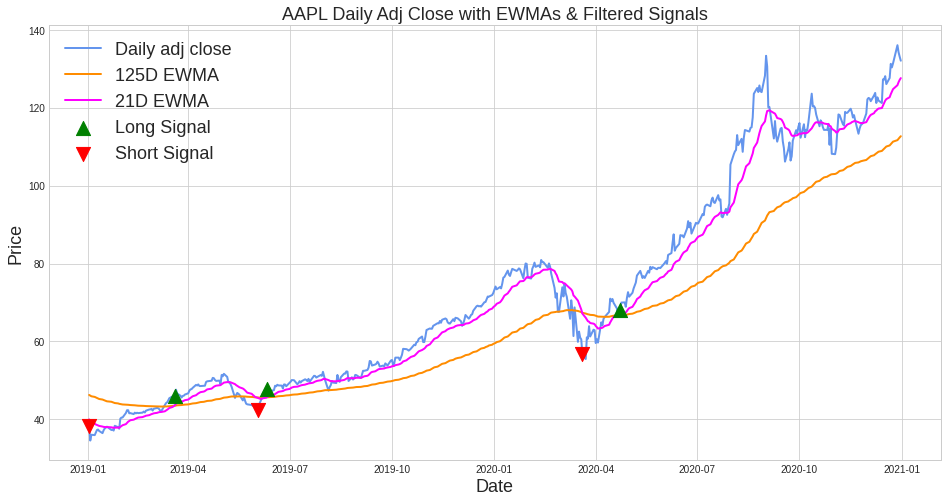

In [14]:
plt.figure(figsize=(16,8))
plt.plot(close_df.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="Daily adj close", linewidth=2, color="cornflowerblue", zorder=1)
plt.plot(slow_ewma_df.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="125D EWMA", linewidth=2, color="darkorange", zorder=2)
plt.plot(fast_ewma_df.loc["2019-01-01":"2021-01-01","AAPL"], alpha=1.0, label="21D EWMA", linewidth=2, color="magenta", zorder=3)
plt.scatter(filtered_signal.index, np.where(filtered_signal.loc[:, "AAPL"]==1, close_df.loc[:,"AAPL"], np.nan), alpha=1, label="Long Signal", marker="^", color="green", s=200, zorder=4)
plt.scatter(filtered_signal.index, np.where(filtered_signal.loc[:, "AAPL"]==-1, close_df.loc[:, "AAPL"], np.nan), alpha=1, label="Short Signal", marker="v", color="red", s=200, zorder=5)
plt.title("AAPL Daily Adj Close with EWMAs & Filtered Signals", fontsize=18)
plt.legend(fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.show()

## Signal returns

In [15]:
def get_lookahead_returns(close, signal):

  entry_signals = signal.copy()
  entry_signals = entry_signals[signal!=0]

  entry_prices = close.copy()
  entry_prices = entry_prices[signal!=0]

  price_returns = entry_prices.copy()

  for ticker in entry_prices:

    valid_indexes = entry_prices.loc[:, ticker].index.get_indexer(entry_prices.loc[:, ticker].index[~entry_prices.loc[:, ticker].isnull()])

    for i in range(len(valid_indexes)):

      current_price = entry_prices.loc[:, ticker].iloc[valid_indexes[i]]

      if i < (len(valid_indexes)-1):
        next_price = entry_prices.loc[:, ticker].iloc[valid_indexes[i+1]]
        price_returns.loc[:, ticker].iloc[valid_indexes[i]] = (next_price / current_price) - 1

      else:
        last_price = close.loc[:, ticker].iloc[-1]
        price_returns.loc[:, ticker].iloc[valid_indexes[i]] = (last_price / current_price) - 1

  signal_returns = entry_signals * price_returns

  return signal_returns

In [16]:
signal_returns = get_lookahead_returns(close_df, filtered_signal)
signal_returns

,AAPL
Date,
2019-01-02,-0.196599
2019-01-03,NaN
2019-01-04,NaN
2019-01-07,NaN
2019-01-08,NaN
...,...
2020-12-24,NaN
2020-12-28,NaN
2020-12-29,NaN


## Visualise signal returns

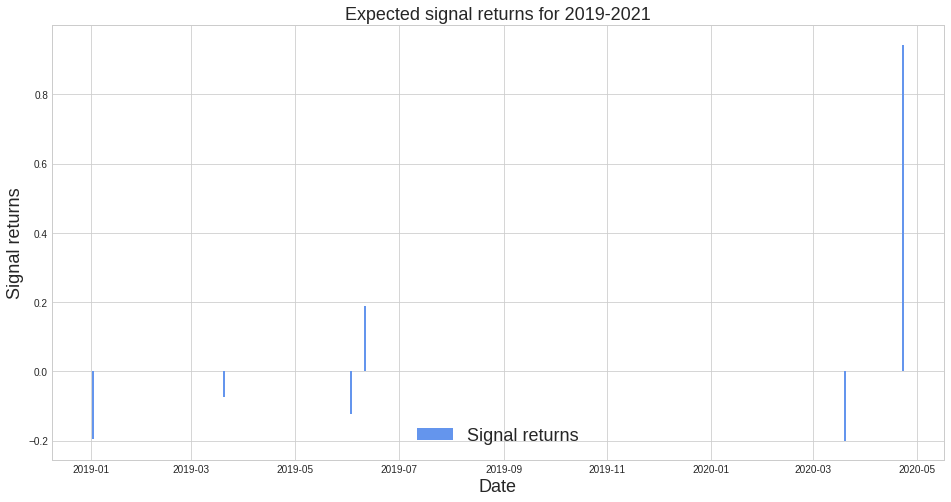

In [17]:
plt.figure(figsize=(16,8))
plt.bar(signal_returns.index, signal_returns.loc[:, "AAPL"], alpha=1.0, label="Signal returns", width=1, color="cornflowerblue", zorder=1)
plt.legend(fontsize=18)
plt.title("Expected signal returns for 2019-2021", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Signal returns", fontsize=18)
plt.show()

## Cumulative returns

In [18]:
signal_cumu_returns = ((signal_returns / len(signal_returns.columns)).sum(axis=1)+1).cumprod()
signal_cumu_returns

Date
2019-01-02    0.803401
2019-01-03    0.803401
2019-01-04    0.803401
2019-01-07    0.803401
2019-01-08    0.803401
                ...   
2020-12-24    1.200675
2020-12-28    1.200675
2020-12-29    1.200675
2020-12-30    1.200675
2020-12-31    1.200675
Length: 505, dtype: float64

In [19]:
buy_hold_cumu_returns = ((close_df / close_df.shift(1) - 1).sum(axis=1)+1).cumprod()
buy_hold_cumu_returns

Date
2019-01-02    1.000000
2019-01-03    0.900393
2019-01-04    0.938830
2019-01-07    0.936740
2019-01-08    0.954597
                ...   
2020-12-24    3.422230
2020-12-28    3.544629
2020-12-29    3.497433
2020-12-30    3.467611
2020-12-31    3.440902
Length: 505, dtype: float64

## Find optimal EWMA spans

In [20]:
stats_table = pd.DataFrame(data={"Stats":["Cumsum (2Y)", "CAGR", "Mean", "Median", "Max", "Min", "St. dev.","Skew", "Kurtosis"]})
stats_table.set_index("Stats", inplace=True)

buy_hold_returns = (close_df / close_df.shift(1) - 1).sum(axis=1)

stats_table["Buy & Hold"] = [(buy_hold_returns+1).cumprod()[-1]-1,
                            ((buy_hold_returns+1).cumprod()[-1])**(1/2)-1,
                            buy_hold_returns.mean(),
                            buy_hold_returns.median(),
                            buy_hold_returns.max(),
                            buy_hold_returns.min(), 
                            buy_hold_returns.std(), 
                            stats.skew(buy_hold_returns.dropna(axis=0)), 
                            stats.kurtosis(buy_hold_returns.dropna(axis=0), fisher=True)]

In [21]:
for i in range(5, 21, 5):
  for j in range(25, 100, 5):

    # get close prices
    close_df = aapl_df.copy()
    close_df = close_df.drop(columns=["Open", "High", "Low", "Volume"])
    close_df = close_df.rename(columns={"Close":"AAPL"})

    # get EWMAs
    fast_ewma_df = close_df.copy()
    fast_ewma_df = EWMA(fast_ewma_df, i)
    slow_ewma_df = close_df.copy()
    slow_ewma_df = EWMA(slow_ewma_df, j)

    # compute signals
    close_df = close_df.loc["2019-01-01":"2021-01-01", :]
    fast_ewma_df = fast_ewma_df.loc["2019-01-01":"2021-01-01", :]
    slow_ewma_df = slow_ewma_df.loc["2019-01-01":"2021-01-01", :]
    signal = get_long_short(fast_ewma_df, slow_ewma_df)

    # filter signal
    filtered_signal = filter_signal(signal)

    # get signal returns
    signal_returns = get_lookahead_returns(close_df, filtered_signal).sum(axis=1)

    # enter signal return stats into table
    stats_table["{}D-Fast / {}D-Slow".format(i, j)] = [(signal_returns+1).cumprod()[-1]-1,
                                                      ((signal_returns+1).cumprod()[-1])**(1/2)-1,
                                                      signal_returns.mean(),
                                                      signal_returns.median(),
                                                      signal_returns.max(),
                                                      signal_returns.min(), 
                                                      signal_returns.std(), 
                                                      stats.skew(signal_returns.dropna(axis=0)), 
                                                      stats.kurtosis(signal_returns.dropna(axis=0), fisher=True)]  

In [22]:
stats_table

,Buy & Hold,5D-Fast / 25D-Slow,5D-Fast / 30D-Slow,5D-Fast / 35D-Slow,5D-Fast / 40D-Slow,5D-Fast / 45D-Slow,5D-Fast / 50D-Slow,5D-Fast / 55D-Slow,5D-Fast / 60D-Slow,5D-Fast / 65D-Slow,5D-Fast / 70D-Slow,5D-Fast / 75D-Slow,5D-Fast / 80D-Slow,5D-Fast / 85D-Slow,5D-Fast / 90D-Slow,5D-Fast / 95D-Slow,10D-Fast / 25D-Slow,10D-Fast / 30D-Slow,10D-Fast / 35D-Slow,10D-Fast / 40D-Slow,10D-Fast / 45D-Slow,10D-Fast / 50D-Slow,10D-Fast / 55D-Slow,10D-Fast / 60D-Slow,10D-Fast / 65D-Slow,10D-Fast / 70D-Slow,10D-Fast / 75D-Slow,10D-Fast / 80D-Slow,10D-Fast / 85D-Slow,10D-Fast / 90D-Slow,10D-Fast / 95D-Slow,15D-Fast / 25D-Slow,15D-Fast / 30D-Slow,15D-Fast / 35D-Slow,15D-Fast / 40D-Slow,15D-Fast / 45D-Slow,15D-Fast / 50D-Slow,15D-Fast / 55D-Slow,15D-Fast / 60D-Slow,15D-Fast / 65D-Slow,15D-Fast / 70D-Slow,15D-Fast / 75D-Slow,15D-Fast / 80D-Slow,15D-Fast / 85D-Slow,15D-Fast / 90D-Slow,15D-Fast / 95D-Slow,20D-Fast / 25D-Slow,20D-Fast / 30D-Slow,20D-Fast / 35D-Slow,20D-Fast / 40D-Slow,20D-Fast / 45D-Slow,20D-Fast / 50D-Slow,20D-Fast / 55D-Slow,20D-Fast / 60D-Slow,20D-Fast / 65D-Slow,20D-Fast / 70D-Slow,20D-Fast / 75D-Slow,20D-Fast / 80D-Slow,20D-Fast / 85D-Slow,20D-Fast / 90D-Slow,20D-Fast / 95D-Slow
Stats,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Cumsum (2Y),2.440902,1.415189,1.066852,0.934105,0.869907,0.734121,1.050993,1.356359,1.032960,1.215757,0.924320,0.713890,0.759824,0.790872,0.641866,1.035486,1.201322,1.079217,1.185653,0.803095,1.051398,0.993400,1.188701,1.500449,1.656321,1.155210,1.058787,1.372262,0.917262,0.672849,0.540894,1.247909,0.714452,0.724493,0.981143,0.939033,1.508836,1.214607,1.009254,1.315640,1.150661,0.652046,0.581616,0.661231,1.114738,0.477598,0.693692,0.909914,0.927923,1.030095,1.330748,0.837023,1.075875,1.012874,0.579529,0.633694,0.896788,0.364989,0.364372,0.418568,0.443966
CAGR,0.854967,0.554088,0.437655,0.390721,0.367445,0.316860,0.432129,0.535044,0.425819,0.488542,0.387199,0.309156,0.326584,0.338235,0.281353,0.426704,0.483685,0.441949,0.478395,0.342794,0.432270,0.411878,0.479426,0.581281,0.629822,0.468063,0.434847,0.540215,0.384652,0.293387,0.241327,0.499303,0.309371,0.313200,0.407531,0.392492,0.583930,0.488156,0.417482,0.521723,0.466513,0.285320,0.257623,0.288888,0.454214,0.215565,0.301419,0.381996,0.388497,0.424814,0.526679,0.355368,0.440790,0.418758,0.256793,0.278160,0.377239,0.168327,0.168063,0.191037,0.201651
Mean,0.002734,0.002265,0.001933,0.001693,0.001587,0.001471,0.001853,0.002152,0.001797,0.001969,0.001716,0.001745,0.001791,0.001834,0.001664,0.002044,0.001947,0.001817,0.002028,0.001551,0.001823,0.001762,0.001999,0.002471,0.002640,0.002160,0.002071,0.002407,0.001959,0.001683,0.001526,0.002037,0.001450,0.001532,0.001735,0.001706,0.002532,0.002240,0.001997,0.002337,0.002160,0.001586,0.001506,0.001652,0.002196,0.001397,0.001449,0.001663,0.001682,0.001828,0.002337,0.001777,0.002066,0.001994,0.001476,0.001540,0.001893,0.001197,0.001196,0.001285,0.001354
Median,0.002548,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Max,0.119808,0.679252,0.646926,0.544514,0.495522,0.495522,0.516058,0.537834,0.536562,0.536562,0.560154,0.877707,0.877707,0.877707,0.877707,0.877707,0.544514,0.509298,0.555068,0.501324,0.546697,0.545418,0.613477,0.887395,0.887395,0.887395,0.887395,0.887395,0.887395,0.941883,0.934358,0.523251,0.521975,0.634001,0.544490,0.567096,0.886062,0.917137,0.856171,0.856171,0.856171,0.856171,0.856171,0.917137,0.917137,0.886062,0.554236,0.545768,0.543399,0.542260,0.856171,0.817822,0.817822,0.817822,0.817822,0.817822,0.8

In [23]:
stats_table.loc["Cumsum (2Y)", :].nlargest(5)

Buy & Hold             2.440902
10D-Fast / 65D-Slow    1.656321
15D-Fast / 50D-Slow    1.508836
10D-Fast / 60D-Slow    1.500449
5D-Fast / 25D-Slow     1.415189
Name: Cumsum (2Y), dtype: float64

In [24]:
stats_table.loc["Mean", :].nlargest(5)

Buy & Hold             0.002734
10D-Fast / 65D-Slow    0.002640
15D-Fast / 50D-Slow    0.002532
10D-Fast / 60D-Slow    0.002471
10D-Fast / 80D-Slow    0.002407
Name: Mean, dtype: float64

In [25]:
stats_table.loc["St. dev.", :].nsmallest(5)

Buy & Hold             0.023808
5D-Fast / 40D-Slow     0.029561
10D-Fast / 30D-Slow    0.030419
5D-Fast / 45D-Slow     0.030980
15D-Fast / 30D-Slow    0.031016
Name: St. dev., dtype: float64